# **Storing encoded images across multiple TFRecord files**
This tutorial is based on HvassLabs tutorial number 18:

- [Notebook](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/18_TFRecords_Dataset_API.ipynb)

- [YouTube video](https://www.youtube.com/watch?v=oxrcZ9uUblI)

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import sys
import pandas as pd
import PIL
from matplotlib.image import imread
print(tf.__version__)

2.2.0


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "gdrive/My Drive/tutorial"

image_by_label.csv  images


In [11]:
data_directory  = "gdrive/My Drive/tutorial/"


##**Plotting some example data:**

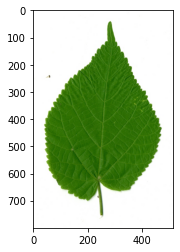

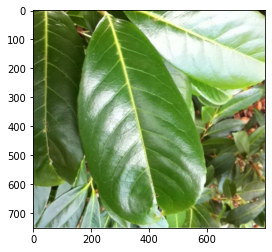

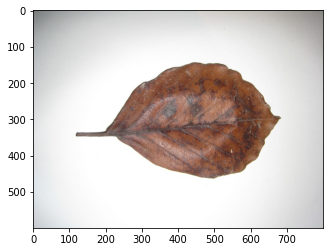

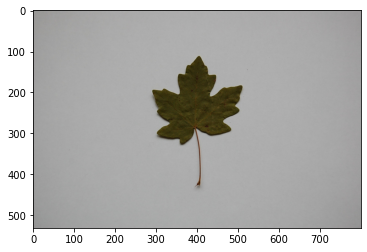

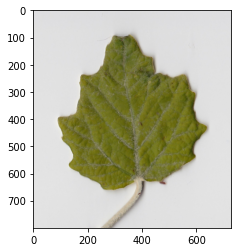

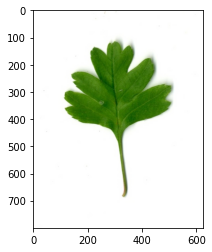

In [10]:
image_paths = os.listdir(data_directory)
for image in image_paths[0:10]:
  if image.endswith('.jpg'):
    img_array = imread(data_directory+'images/'+image)
    plt.imshow(img_array)
    plt.show()

##**Load our csv containing label information for each image:**

Entries in this file maps image names to its respective labels.  

In [24]:
label_list = pd.read_csv(data_directory+"image_by_label.csv") 
label_list = label_list.drop(label_list.columns[0],axis=1)
label_list

,image,label
0,6998.jpg,53
1,1895.jpg,5
2,17446.jpg,70
3,25996.jpg,75
4,9412.jpg,75
...,...,...
5087,15381.jpg,225
5088,16734.jpg,225
5089,22142.jpg,225
5090,4841.jpg,225


###**Helper functions:**

In [25]:
def wrap_int64(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def wrap_bytes(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def print_progress(count, total):
    pct_complete = float(count) / total
    msg = "\r- Progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

###**First step is to create a function to convert our images into TFRecords.**### 

The TFRecord files consists of multiple tf.Examples serialized in a binary format. 

The tf.Examples contains a dict mapping strings into tf.train.Feature from wich we will able to code and decode raw data.     

In [56]:
def convert(image_paths, labels, out_path):
    # Args:
    # image_paths   List of file-paths for the images.
    # labels        Class-labels for the images.
    # out_path      File-path for the TFRecords output file.    
    print("Converting to output path: " + out_path)

    # Number of images. Used when printing the progress.
    num_images = len(image_paths)
    
    # Open a TFRecordWriter for the output-file.
    with tf.io.TFRecordWriter(out_path) as writer:
        
        # Iterate over the images reading, encoding into jpeg and
        # storing their bytes alongside with the label bytes into
        # a TFRecord file.
        for i in range(num_images):
            # Print the percentage-progress.
            print_progress(count=i, total=num_images-1)
            
            # Load the image-file using matplotlib's imread function.
            image_name = image_paths.loc[i][0]
            # Get the label from image name
            label = image_paths.loc[i][1]
            # Read image
            img = imread(data_directory+'images/'+image_name)

            # Encode image raw bytes into in order to save storage.
            img_bytes = tf.io.encode_jpeg(img).numpy()

            # Create a dict with the data we want to save in the
            # TFRecords file. You can add more relevant data here.
            data = \
                {
                    'image': wrap_bytes(img_bytes),
                    'label': wrap_int64(label)
            }

            # Wrap the data as TensorFlow Features.
            feature = tf.train.Features(feature=data)

            # Wrap again as a TensorFlow Example.
            example = tf.train.Example(features=feature)

            # Serialize the data.
            serialized = example.SerializeToString()
            
            # Write the serialized data to the TFRecords file.
            writer.write(serialized)

### **Next step is to create our serialization loop, in which we will input our images into the convert function pipeline.**

The tensorflow [documentation](https://www.tensorflow.org/tutorials/load_data/tfrecord) recommends splitting our data into 100-200mb files, since our set is composed of 5092 images we will divide our data between **5 files containing 1000 samples** each, plus a **single file with the remaining subset**.

In [58]:

n_images = len(label_list)
# Define the number of samples by file
n_items = 1000 
# Define the number of records in which the data will be splitted over
n_records = int(n_images / n_items) + 1
# Define the lenght of the remaining subset of images
rest = n_images % n_items

# Define the output directory:
out_dir = data_directory+'TFRecords/data_{}.tfrecord'

# This variable stores the distribution stopping point, that be the point
# in which the samples will stop being equally distributed over xx images per tf record
# and the remaining subset over a single one.
total = n_images - rest

sample_index = 0
# Splits the dataset over 5(folds) tfrecords containing 1000 images each + 1 record contaning 92 (rest).
for record in range((n_records)):
    print('Record: '+ str(record)+' from: ' + str(n_records)+'\n')
    fmt_path = out_dir.format(record)

    if not sample_index == total:
        limit = sample_index + n_items
        print('converting from: ' + str(sample_index)+' to: ' + str(limit))
        path_subset = label_list[sample_index : (limit)]      
        sample_index = limit
        convert(path_subset, label_list, fmt_path)
    else:
        path_subset = label_list[sample_index : (sample_index + (rest))]  
        print('converting from: ' + str(sample_index)+' to: ' + str(sample_index + (rest)))
        convert(path_subset, label_list, fmt_path)
        sample_index = sample_index + rest

Record: 0 from: 6

converting from: 0 to: 1000
Converting to output path: gdrive/My Drive/tutorial/TFRecords/data_0.tfrecord
- Progress: 100.0%

### **Next step is to create a function to parse back encoded data.** 

In [60]:
def parsing_fn(serialized):
    # Define a dict with the data-names and types we expect to
    # find in the TFRecords file.
    features = \
        {
            'image': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64)            
        }

    # Parse the serialized data so we get a dict with our data.
    parsed_example = tf.io.parse_single_example(serialized=serialized,
                                             features=features)
    # Get the image as raw bytes.
    image_raw = parsed_example['image']

    # Decode the raw bytes so it becomes a tensor with type.
    image = tf.io.decode_jpeg(image_raw)
    
    # Get the label associated with the image.
    label = parsed_example['label']
    
    # The image and label are now correct TensorFlow types.
    return image, label

### Load the TFRecord file and plot some images to check if everything is all right.

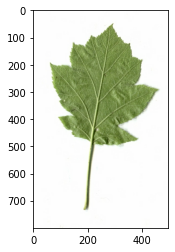

Label:  53


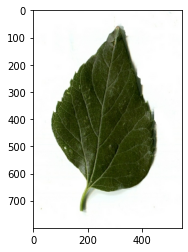

Label:  5


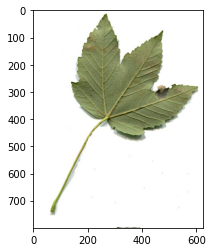

Label:  70


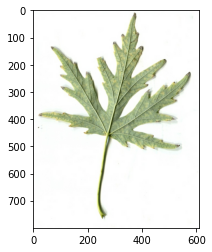

Label:  75


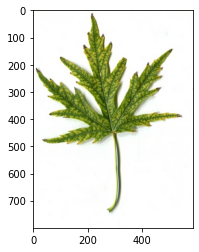

Label:  75


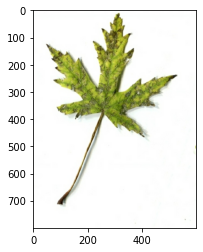

Label:  75


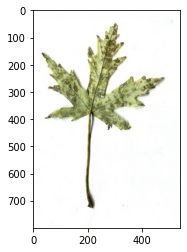

Label:  75


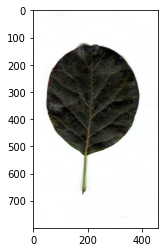

Label:  58


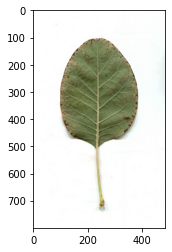

Label:  58


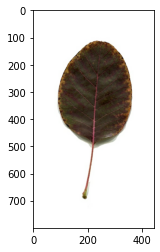

Label:  58


In [68]:
# LOAD TFRECORD
# Define the tf records path
records_path = data_directory+'TFRecords'+'/data_0.tfrecord'
# Create a dataset
dataset = tf.data.TFRecordDataset(filenames=records_path)
# Map our dataset to the parsing function 
parsed_dataset = dataset.map(parsing_fn)
# Iterates through all images to see if everything worked as expected.
iterator = tf.compat.v1.data.make_one_shot_iterator(parsed_dataset) 
for i in range(10):
  image,label = iterator.get_next()
  img_array = image.numpy()
  img_array = img_array.astype(np.uint8) # Cast into matplotlib expected format since image original type is float32.
  plt.imshow(img_array)
  plt.show()
  print('Label: ',label.numpy())